# E-commerce Data Analysis

1. **EDA and preprocessing:** E-commerce dataset will be analyzed and processed for next steps.
2. **Cohort and Retention Analysis:** Conduct cohort analysis and find out monthly retention rates.
3. **RFM:** Customers of an online retailer will be classified into clusters based on transactions over a year.
4. **CLTV:** Find out expected transactions, revenues from customers and their lifetime values to the retailer.
5. **Time-series analysis:** Forecasting revenue for next month.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from datetime import datetime, timedelta

import datetime as dt
import seaborn as sns

# 1. Data Preprocessing and Exploration

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/Can-Berk/Data_Analysis/main/Datasets/uk_retailer_data.csv", encoding= 'unicode_escape')
print(data.shape)
print(data.dtypes)
data.head()

(541909, 8)
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Dataset contains of 541,909 transactions and each rows contains information on transaction details.

    -InvoiceNo is a nominal 6 digit feature that comes from a single purchase. Starting with 'C' stands for cancelled order.
    -StockCode is a nominal distinct product code.
    -Description is a nominal product name.
    -Quantity is a numeric feature that shows how many of any given product purchased in the order.
    -InvoiceDate shows the transaction date and time.
    -UnitPrice is a numeric feature that stands for price of item
    -CustomerID is a nominal distinct customer code.
    -Country is a nominal feature that shows country of customer.

Invoice date should be datetime type.

In [3]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date

In [4]:
print("Starting Date: {}\nLast Date: {}".format(data['InvoiceDate'].min(), data['InvoiceDate'].max()))

Starting Date: 2010-12-01
Last Date: 2011-12-09


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
(data['InvoiceDate']).dtype

dtype('O')

Extreme outliers in UnitPrice will be handled later as they affect predictions negatively.

## Missing Values

In [7]:
null_data = data.isnull().sum()
null_percent = null_data.apply(lambda x: x/len(data)*100)
null = null_data.to_frame(name="total_null").join(null_percent.to_frame(name="prc"))
null['prc'] = null['prc'].apply("{:,.2f}%".format)
null

,total_null,prc
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,1454,0.27%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,135080,24.93%
Country,0,0.00%


In [8]:
data[data['CustomerID'].isnull()]['Description'].isnull().value_counts()    # Missing description among null CustomerID entries

False    133626
True       1454
Name: Description, dtype: int64

In [9]:
data[(data['CustomerID'].isnull()) & (data['Description'].isnull())].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01,0.0,NaN,United Kingdom


Total 135,080 missing data in CustomerID which comprimises 24.93% of the total data and among them 1454 of them have missing Description. All of the Unit prices are 0 for items without Customer ID. Reason to record them isn't clear and imputing values are not possible with the data available. Therefore, I'm going to drop the entries with missing values along with the duplicated entries.

In [10]:
data.dropna(inplace=True)

## Duplicated entries

In [11]:
print('Total duplicated entries= {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace=True)
print('Data length updated to= {}'.format(len(data)))

Total duplicated entries= 5226
Data length updated to= 401603


## Exploration

**Unique products, customers, transactions**

In [12]:
pd.DataFrame([{"Customers": data['CustomerID'].nunique(),
               "Products": data['StockCode'].nunique(),
               "Transactions": data['InvoiceNo'].nunique()}], index=["Unique"])

,Customers,Products,Transactions
Unique,4372,3684,22190


Total of 4372 customers had 22,190 transactions over 3684 products.

### Outliers

***2 Options are: replace outliers or remove them***

In [13]:
# low_price = data['UnitPrice'].quantile(0.01)
# high_price = data['UnitPrice'].quantile(0.99)
# print((low_price, high_price))

# low_quantity = data['Quantity'].quantile(0.01)
# high_quantity = data['Quantity'].quantile(0.99)
# print((low_quantity, high_quantity))

# data = data[(data['UnitPrice']<high_price) & (data['UnitPrice']>low_price)]
# data = data[(data['Quantity']<high_quantity) & (data['Quantity']>low_quantity)]

**Cancelled orders**

In [14]:
# data['Cancelled_orders'] = np.where(data['InvoiceNo'].str.startswith('C'), 'Yes', 'No')
cancelled_orders = data[data['InvoiceNo'].str.startswith("C")]
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom


In [15]:
data['InvoiceNo'].nunique()

22190

In [16]:
print('Percentage of cancelled orders among the transactions: {:.2f}%'.format(cancelled_orders['InvoiceNo'].nunique()/data['InvoiceNo'].nunique()*100))

Percentage of cancelled orders among the transactions: 16.47%


There are 22,190 transactions in total and 16.47% of them are cancelled. They are going to be removed as not good data for prediction.

**Gonna remove negative quantities, however, this part can be improved by negating cancelled orders by matching given-cancelled orders.**

In [17]:
data = data[data['Quantity']>0]

**Adding a Total Price column**

In [18]:
data = data.assign(TotalPrice=lambda data: data['Quantity']*data['UnitPrice'])

In [19]:
data.reset_index(drop=True, inplace=True); data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
392726,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France,10.20
392727,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,12.60
392728,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,16.60
392729,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,16.60


**Most popular products**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


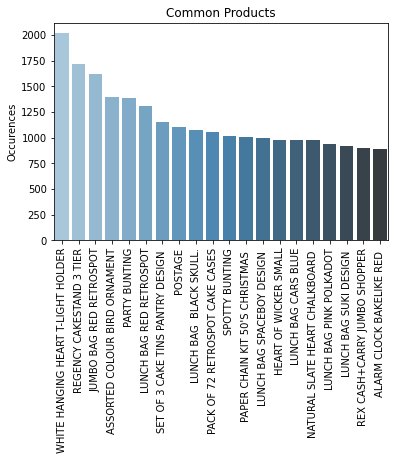

In [20]:
popular_products = data['Description'].value_counts().sort_values(ascending=False).iloc[:20]
sns.barplot(popular_products.index, popular_products.values, palette="Blues_d")
plt.xticks(rotation=90)
plt.ylabel("Occurences")
plt.title("Common Products")
plt.show()

**Most common country**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


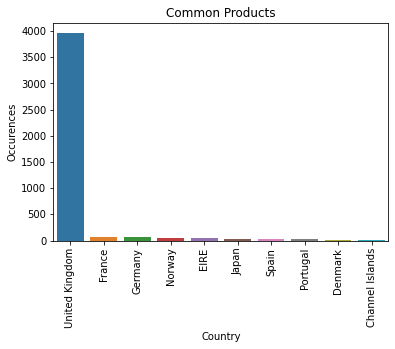

In [21]:
country_customers=data.iloc[data['CustomerID'].unique()].groupby(['Country'])['CustomerID'].count().sort_values(ascending=False)
sns.barplot(country_customers.index, country_customers.values)
plt.xticks(rotation=90)
plt.ylabel("Occurences")
plt.title("Common Products")
plt.show()

Most customers are located in United Kingdom.

**Most products sold to these countries**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


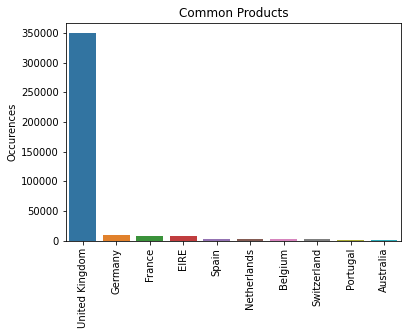

In [22]:
country_orders = data['Country'].value_counts().sort_values(ascending=False).iloc[:10]
sns.barplot(country_orders.index, country_orders.values)
plt.xticks(rotation=90)
plt.ylabel("Occurences")
plt.title("Common Products")
plt.show()

Similarly most products are sold to customers in United Kingdom.

**Most spending customers**

In [23]:
data.groupby(['CustomerID', 'Country'], as_index=False)['InvoiceNo'].count().rename(columns={'InvoiceNo': 'Quantity_bought'}).sort_values(by='Quantity_bought', ascending=False)

,CustomerID,Country,Quantity_bought
4019,17841.0,United Kingdom,7676
1888,14911.0,EIRE,5672
1298,14096.0,United Kingdom,5111
334,12748.0,United Kingdom,4413
1670,14606.0,United Kingdom,2677
...,...,...,...
605,13135.0,United Kingdom,1
728,13302.0,United Kingdom,1
4082,17923.0,United Kingdom,1
643,13185.0,United Kingdom,1


Customer with ID: 17841 from United Kingdom has the highest number of quantity bought from the retailer.

In [24]:
total_spending = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum().rename(columns={'TotalPrice': 'TotalSpent'})
total_spending[['CustomerID', 'TotalSpent']].sort_values(by='TotalSpent', ascending=False).iloc[:10]

,CustomerID,TotalSpent
12891,16446.0,168469.60
0,12346.0,77183.60
9022,15098.0,38970.00
15870,17450.0,31698.16
164,12415.0,22775.93
18016,18102.0,22206.00
15867,17450.0,22104.80
169,12415.0,21880.44
10900,15749.0,21535.90
7438,14646.0,20277.92


CustomerID:16446.0 has the biggest amount spent with 168,469.60€.

# 2.A Cohort Analysis - Monthly
Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time or is only appearing to improve because of growth.

In [25]:
# data['InvoiceCohort'] = [x.strftime("%Y-%m") for x in data['InvoiceDate']]
data['InvoiceCohort'] = pd.to_datetime(data['InvoiceDate']).dt.to_period('M')
data['InvoiceCohort'] = data.groupby(['CustomerID'])['InvoiceCohort'].transform(min)
# InvoiceCohort column shows the first time purchase

In [26]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceCohort
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010-12


In [27]:
cohort_id = []
for x in range(len(data)):
    cohort_id.append(12*(data.loc[x, 'InvoiceDate'].year - data.loc[x, 'InvoiceCohort'].year) + 
             (data.loc[x, 'InvoiceDate'].month - data.loc[x, 'InvoiceCohort'].month) + 1)

data['CohortID'] = cohort_id

In [28]:
cohort = data.groupby(['CohortID', 'InvoiceCohort'], as_index=False)['CustomerID'].nunique().rename(columns={'CustomerID': 'Retain_cus'})
cohort

,CohortID,InvoiceCohort,Retain_cus
0,1,2010-12,885
1,1,2011-01,417
2,1,2011-02,380
3,1,2011-03,452
4,1,2011-04,300
...,...,...,...
86,11,2011-01,152
87,11,2011-02,26
88,12,2010-12,445
89,12,2011-01,49


In [29]:
cohort_pivot = cohort.pivot(index='InvoiceCohort', columns='CohortID', values='Retain_cus')
cohort_pivot.loc['AllUsers']= cohort_pivot.sum()
cohort_pivot

CohortID,1,2,3,4,5,6,7,8,9,10,11,12,13
InvoiceCohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**417 users made their first purchase in January 2011. Consecutive month 92 of these users made another purchase. On the 10th month after making first purchase on January 2011, 152 customers out of 417 were still active.**

# 2.B Retention Rate - Monthly

In [30]:
cust_acquisition_day = cohort_pivot.iloc[:, 0]
retention_table = round(cohort_pivot.divide(cust_acquisition_day, axis=0), 2)
retention_table.iloc[-1:,1:] = list(round(retention_table.iloc[:-1, 1:].mean(), 2))

# for col in retention_table:
#     retention_table[col] = np.where(retention_table[col].notnull(), retention_table[col].astype(str).add(' %'), retention_table[col])

**See the percentage of retained customers based on their first time purchase month.**

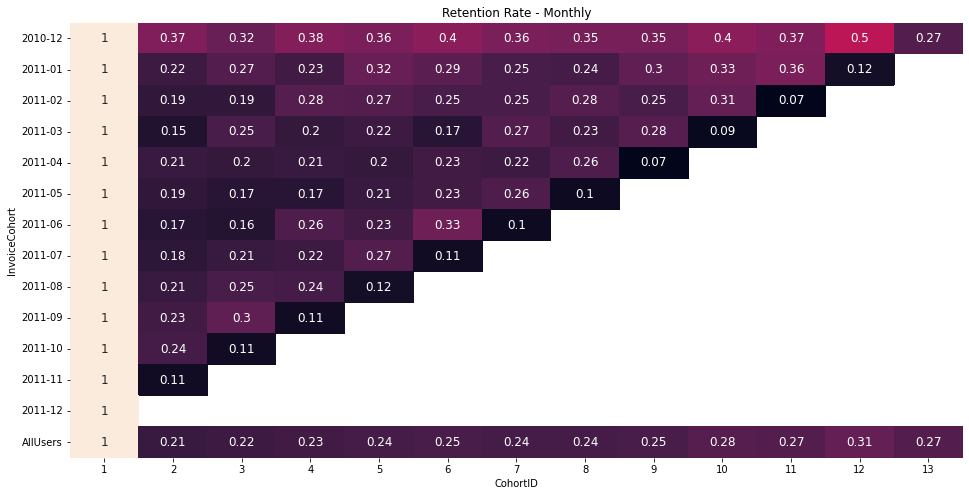

In [31]:
plt.rcParams["axes.facecolor"] = "white"
fig, ax = plt.subplots(figsize = (16, 8))

sns.heatmap(retention_table, annot = True, annot_kws = {"fontsize": 12}, cbar = False, ax = ax)

plt.title("Retention Rate - Monthly")
plt.show()

Out of all of the new customers during this time range 21% customers are retained in 1st month and 27% in 12th month.

In [32]:
# data.groupby(['CohortID'], as_index=False)["CustomerID"].nunique()

# monthly_new_customers = data.groupby(['InvoiceCohort'], as_index=False)['CustomerID'].nunique().rename(columns=({'CustomerID': 'Customers'}))
# #Customer made first time purchase
# monthly_customers = monthly_new_customers['Customers'].cumsum()[::-1]
# monthly_customers

# sns.lineplot(x = monthly_customers.index , y = monthly_customers['CustomerID'],  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

# 3. RFM Analysis
    -Recency: Last time purchase of a customer.
    -Frequency: More frequent customer buy indicates higher engagement.
    -Monetary: Level of spending.
    
**Way to distinguish between customer segments:**
    -

In [33]:
data['InvoiceDate'].max()

datetime.date(2011, 12, 9)

In [34]:
last_day = dt.date(2011, 12, 10)

### Creating a dataframe for recency, frequency and monetary of customers

In [35]:
recency_df = data.groupby(['CustomerID'], as_index=False)['InvoiceDate'].max()
recency_df['Recency'] = recency_df['InvoiceDate'].apply(lambda x: (last_day-x).days)
recency_df.drop('InvoiceDate', axis=1, inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,3
2,12348.0,76
3,12349.0,19
4,12350.0,311


In [36]:
frequency_df = data.groupby(['CustomerID'], as_index=False)['InvoiceNo'].nunique().rename(columns={'InvoiceNo': 'Frequency'})
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [37]:
monetary_df = data.groupby(['CustomerID'], as_index=False)['TotalPrice'].sum().rename(columns={'TotalPrice': 'Monetary'})
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [38]:
rf = pd.merge(recency_df, frequency_df, on='CustomerID', how='left')
rfm = pd.merge(rf, monetary_df, on='CustomerID', how='left')
rfm.set_index('CustomerID', inplace=True)
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [39]:
### Alternative way
# rfm = data.groupby(['CustomerID'], as_index=False).agg({'InvoiceDate': lambda x: (last_day-x.max()).days,
#                                                   'InvoiceNo': lambda x: x.nunique(),
#                                                    'TotalPrice': lambda x: x.sum()})

# rfm.set_index('CustomerID', inplace=True)
# rfm.columns = ['Recency', 'Frequency', 'Monetary']
# rfm.head()

In [40]:
#**
rfm['Recency_score'] = pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])
rfm['Frequency_score'] = pd.qcut(rfm['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm['Monetary_score'] = pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5])
rfm['RFM_SCORE'] = rfm['Recency_score'].astype(str) + rfm['Frequency_score'].astype(str)


#https://medium.com/@ilaydakursun/customer-segmentation-with-rfm-analysis-learn-more-about-your-customers-f12b348acbd
#https://futurice.com/blog/know-your-customers-with-rfm
#https://guillaume-martin.github.io/rfm-segmentation-with-python.html
seg_map = {r'[1-2][1-2]': 'Hibernating',
           r'[1-2][3-4]': 'At_Risk',
           r'[1-2]5': 'Cant_loose',
           r'3[1-2]': 'About_to_sleep',
           r'33': 'Need_attention',
           r'[3-4][4-5]': 'Loyal_customers',
           r'41': 'Promising',
           r'51': 'New_customers',
           r'[4-5][2-3]': 'Potential_loyalists',
           r'5[4-5]': 'Champions'}

rfm['Segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,Hibernating
12347.0,3,7,4310.00,5,5,5,55,Champions
12348.0,76,4,1797.24,2,4,4,24,At_Risk
12349.0,19,1,1757.55,4,1,4,41,Promising
12350.0,311,1,334.40,1,1,2,11,Hibernating


### Explanation on segments
- Champions: Bought recently, buy often and spend the most

- Loyal customers: Buy on a regular basis. Responsive to promotions.

- Potential loyalist: Recent customers with average frequency.

- Recent customers: Bought most recently, but not often.

- Promising: Recent shoppers, but haven’t spent much.

- Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.

- About to sleep: Below average recency and frequency. Will lose them if not reactivated.

- At risk: Some time since they’ve purchased. Need to bring them back!

- Can’t lose them: Used to purchase frequently but haven’t returned for a long time.

- Hibernating: Last purchase was long back and low number of orders. May be lost.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


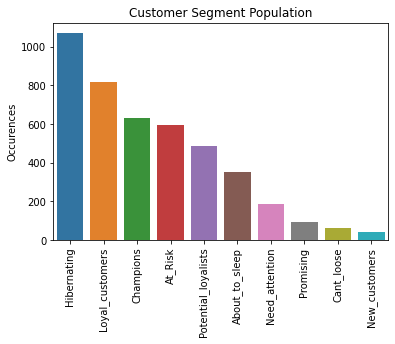

In [41]:
sns.barplot(rfm['Segment'].value_counts().index, rfm['Segment'].value_counts().values)
plt.xticks(rotation=90)
plt.ylabel("Occurences")
plt.title("Customer Segment Population")
sns.set(rc = {'figure.figsize':(16,12)})

On the one hand, Champions segment and Loyal customers are crucial for the retailers business and these segments should be focused by loyalty programs. 

On the other hand, New customers usually turns into hibernating customers. It would be cheaper to retain them than finding new ones, so these segments should be reminded by product recommendation emails. Marketing actions like promotion should be taken for customers in At Risk and Can't Lose segment as once they were frequent buyers.

## K-means clustering

In [42]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [43]:
kmeans_data = rfm.loc[:,['RFM_SCORE']]

score = []
k = list(range(1,10))
for i in k:
    kmean = KMeans(n_clusters=i)
    kmean.fit(kmeans_data)
    score.append(kmean.inertia_)

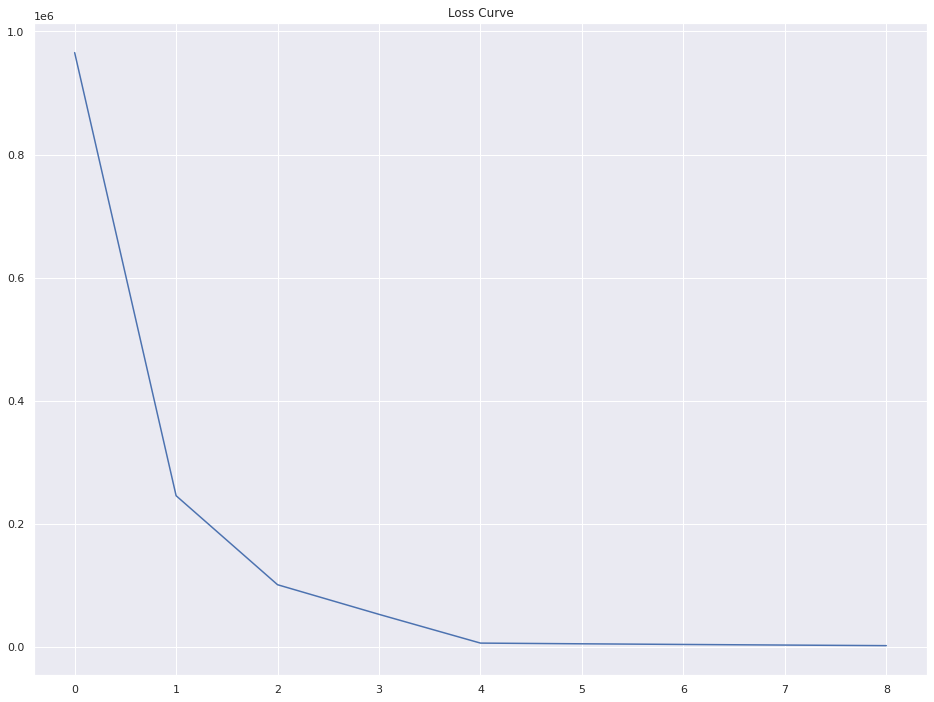

In [44]:
plt.plot(score)
plt.rcParams["figure.figsize"] = (8,6)
plt.title("Loss Curve")
plt.show()

In [45]:
kmeans = KMeans(n_clusters = 4,random_state = 42)
kmeans.fit(kmeans_data)
print('Silhouette Score: {}'.format(round(metrics.silhouette_score(kmeans_data, kmeans.labels_), 2)))

Silhouette Score: 0.73


Performance of clustering technique via Silhouette Coefficient is 0.73 where 1 is maximum score.

In [46]:
rfm['Cluster'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE,Segment,Cluster
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,Hibernating,2
12347.0,3,7,4310.00,5,5,5,55,Champions,1
12348.0,76,4,1797.24,2,4,4,24,At_Risk,3
12349.0,19,1,1757.55,4,1,4,41,Promising,0
12350.0,311,1,334.40,1,1,2,11,Hibernating,2


In [47]:
rfm[['Recency', 'Frequency', 'Monetary', 'Cluster']].groupby(['Cluster']).agg({'mean', 'std', 'max', 'min'})

Recency                             Frequency                       \
            max        mean        std  min       max      mean        std   
Cluster                                                                      
0            72   49.044885  13.732672   15        63  2.915449   3.182395   
1            33   14.567715   9.509187    1       210  7.453446  11.394428   
2           374  269.527294  56.945227  181        34  1.506388   1.506272   
3           180  116.124711  33.119970   73        17  2.445727   1.962642   

              Monetary                                    
        min        max         mean           std    min  
Cluster                                                   
0         1   80850.84  1207.855136   3075.291750   0.00  
1         1  280206.02  3864.006675  13942.902109  20.80  
2         1   77183.60   644.778631   3363.753327   3.75  
3         1   11072.67   905.148189   1106.763874  13.30

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


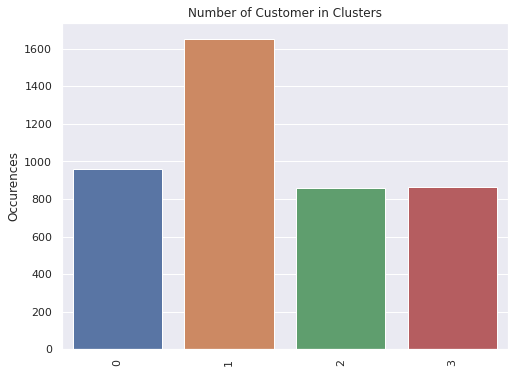

In [48]:
sns.barplot(rfm['Cluster'].value_counts().index, rfm['Cluster'].value_counts().values)
plt.xticks(rotation=90)
plt.ylabel("Occurences")
plt.title("Number of Customer in Clusters")
sns.set(rc = {'figure.figsize':(10,6)})

In [49]:
rfm[rfm['Cluster'] == 1]['Segment'].value_counts()

Champions              633
Loyal_customers        495
Potential_loyalists    484
New_customers           42
Name: Segment, dtype: int64

**Most customers are in Cluster 1 which is comprimised of Champions, Loyal customers, Potential loyalists and New customers.**

# 4. Customer Value

In [50]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import warnings
warnings.filterwarnings('ignore')

In [52]:
cus_df = data.groupby('CustomerID').agg({'InvoiceDate': [lambda x: (x.max() - x.min()).days, lambda x: (last_day - x.min()).days], 
                                        'InvoiceNo': 'nunique',
                                        'TotalPrice': 'sum'})

cus_df.columns = cus_df.columns.droplevel(0)
cus_df.columns = ['Recency', 'T', 'Frequency', 'Monetary']
cus_df.head()

,Recency,T,Frequency,Monetary
CustomerID,,,,
12346.0,0,326,1,77183.60
12347.0,365,368,7,4310.00
12348.0,283,359,4,1797.24
12349.0,0,19,1,1757.55
12350.0,0,311,1,334.40


### Customer Average Order Value TOP 10

In [53]:
(cus_df['Monetary']/cus_df['Frequency']).sort_values(ascending=False).iloc[:10]

CustomerID
16446.0    84236.250000
12346.0    77183.600000
15749.0    14844.766667
15098.0    13305.500000
12357.0     6207.670000
12415.0     5948.310952
12590.0     4932.130000
12688.0     4873.810000
12752.0     4366.780000
18102.0     4327.621667
dtype: float64

In [54]:
cus_df = cus_df[(cus_df['Frequency'] > 1)]

*BetaGeoFitter/Negative binomial distribution*

In [55]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cus_df['Frequency'],
        cus_df['Recency'],
        cus_df['T'], 
        cus_df['Monetary'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.01, alpha: 13.21, b: 1.34, r: 1.04>

### Expected transactions for the next month

In [56]:
bgf.predict(30, cus_df['Frequency'],
            cus_df['Recency'],
            cus_df['T']).sum()

2354.551160774392

### Expected Top 10 customers in the next month

In [57]:
bgf.conditional_expected_number_of_purchases_up_to_time(30,
                                                        cus_df['Frequency'],
                                                        cus_df['Recency'],
                                                        cus_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    16.342360
14911.0    15.644366
17841.0     9.682047
13089.0     7.670044
16000.0     7.365656
14606.0     7.281548
15311.0     7.126983
12971.0     6.756123
15060.0     6.281769
14646.0     6.109907
dtype: float64

*Gamma - Gamma model*

In [58]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

# cus_df = cus_df[(cus_df['Frequency'] > 1)]
ggf.fit(cus_df['Frequency'], cus_df['Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.26, q: 0.22, v: 3.20>

### Customer Lifetime Value Analysis

In [59]:
cltv = ggf.customer_lifetime_value(bgf,cus_df['Frequency'],
                                   cus_df['Recency'],cus_df['T'],
                                   cus_df['Monetary'],time=12,
                                   freq="D",discount_rate=0.01)

cltv = cltv.reset_index()
(round(cltv.sort_values(by="clv", ascending=False)).head(10)).style.format({'clv': '{:,.2f}'})

,CustomerID,clv
1257,14911.000000,"25,241,256.00"
1122,14646.000000,"19,257,134.00"
2761,18102.000000,"14,033,074.00"
2458,17450.000000,"8,101,724.00"
215,12748.000000,"6,064,134.00"
874,14156.000000,"5,753,666.00"
373,13089.000000,"5,066,349.00"
1441,15311.000000,"4,858,435.00"
2652,17841.000000,"4,407,744.00"
1772,16029.000000,"3,881,475.00"


Above frame shows the expected customers in top 10 CLTV to the retailer for next year

# 5. Time Series Analysis

In [60]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [61]:
data = data[data['Country'] == 'United Kingdom']
data.set_index('InvoiceDate', inplace=True)
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,InvoiceCohort,CohortID
InvoiceDate,,,,,,,,,,
2010-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12,1
2010-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12,1
2010-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010-12,1
2010-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010-12,1
2010-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010-12,1


In [62]:
revenue_monthly = (data.groupby(['InvoiceDate'])['TotalPrice'].sum()).resample('M').sum().to_frame()
revenue_monthly

,TotalPrice
InvoiceDate,
2010-12-31,496477.340
2011-01-31,440876.330
2011-02-28,354618.200
2011-03-31,465784.190
2011-04-30,408733.111
2011-05-31,550359.350
2011-06-30,523775.590
2011-07-31,484545.591
2011-08-31,497194.910


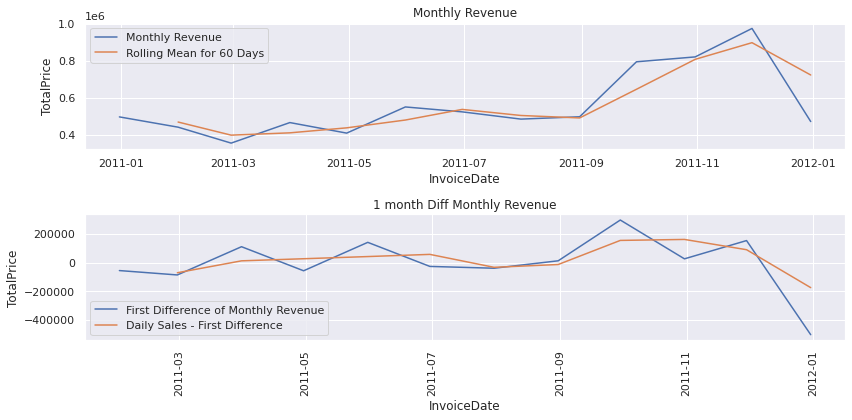

In [63]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))

# revenue_monthly.plot(ax=ax)
sns.lineplot(x = revenue_monthly.index, y = revenue_monthly.TotalPrice, ax=axes[0], label = "Monthly Revenue").set_title("Monthly Revenue")
sns.lineplot(x = revenue_monthly.index, y = revenue_monthly.TotalPrice.rolling(2).mean(), ax=axes[0],
             label = "Rolling Mean for 60 Days")

sns.lineplot(x = revenue_monthly.index, y = revenue_monthly.TotalPrice.diff(1), label = "First Difference of Monthly Revenue")
sns.lineplot(x = revenue_monthly.index, y = revenue_monthly.TotalPrice.diff(1).rolling(2).mean(), ax=axes[1],
             label = "Daily Sales - First Difference").set_title("1st Difference of Work Days Daily Sales")
plt.title("1 month Diff Monthly Revenue")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()

Revenues make a first peak around May and second peak in October. November revenues got highest for the retailer.

## Stationarity

Stationarity means constant mean, variance on different times. Above graph shows mean values increase over time.

### Augmented Dickey-Fuller Test

In [64]:
from statsmodels.tsa.stattools import adfuller

In [65]:
def adf_test(series, check = 0.05):
    
    adf = adfuller(series, autolag = "AIC")
    
    print(f"H0: {series.name} is non-stationary.")
    print(f"H1: {series.name} is stationary.\n")
    
    test_stat = adf[0]; print(f"ADF test statistic: {adf[0]}")
    pvalue = adf[1]; print(f"p-value: {adf[1]}")
    print(f"Number of lags: {adf[2]}")    
    print("\nCritical Values : \n")
    for key, item in adf[4].items(): print("\t", key, "\t", item)
    
    print(f"\nFor {check} significance level: \n")
    if pvalue < check:
        print("We can reject null hypothesis. This series is stationary.")
    else:
        print("We can not reject null hypothesis. This series is non-stationary.")

In [66]:
adf_test(revenue_monthly['TotalPrice'], check=0.1)

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -1.8528859490358536
p-value: 0.35453901071168337
Number of lags: 0

Critical Values : 

	 1% 	 -4.137829282407408
	 5% 	 -3.1549724074074077
	 10% 	 -2.7144769444444443

For 0.1 significance level: 

We can not reject null hypothesis. This series is non-stationary.


> To make the time-series stationary:
1. Taking difference
2. Applying transformations

**Let's take difference as above graph shows mean becomes approximately constant after taking 1st difference**

In [67]:
adf_test(revenue_monthly["TotalPrice"].diff(1).dropna(), check=0.1)

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -2.7175133469123165
p-value: 0.07105641569664628
Number of lags: 2

Critical Values : 

	 1% 	 -4.473135048010974
	 5% 	 -3.28988060356653
	 10% 	 -2.7723823456790124

For 0.1 significance level: 

We can reject null hypothesis. This series is stationary.


## Seasonality and Decomposition

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

In [69]:
decompose = seasonal_decompose(revenue_monthly["TotalPrice"], freq=2)

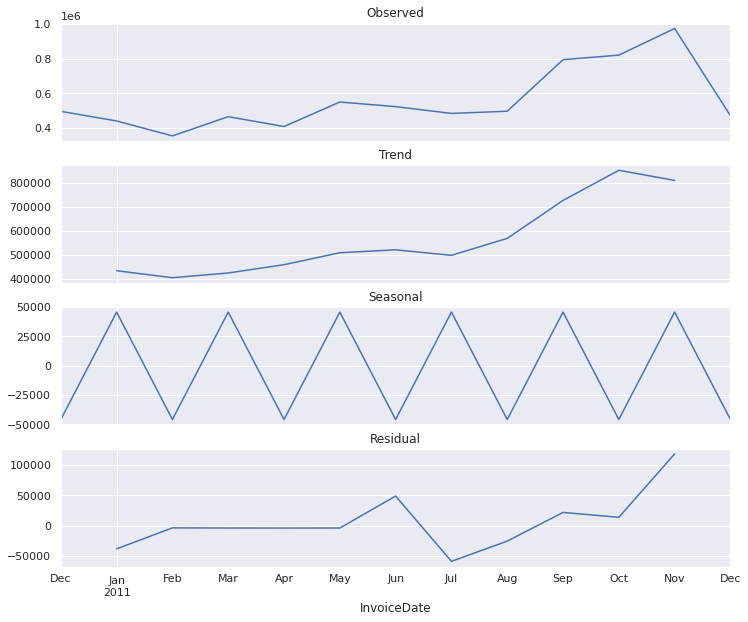

In [70]:
fig, ax = plt.subplots(4, 1, sharex = True, figsize = (12, 10))

decompose.observed.plot(ax = ax[0]).set_title("Observed")
decompose.trend.plot(ax = ax[1]).set_title("Trend")
decompose.seasonal.plot(ax = ax[2]).set_title("Seasonal")
decompose.resid.plot(ax = ax[3]).set_title("Residual")

plt.show()

Above graph shows the monthly seasonality, trend and residuals. Let's see if residuals are normally distributed.

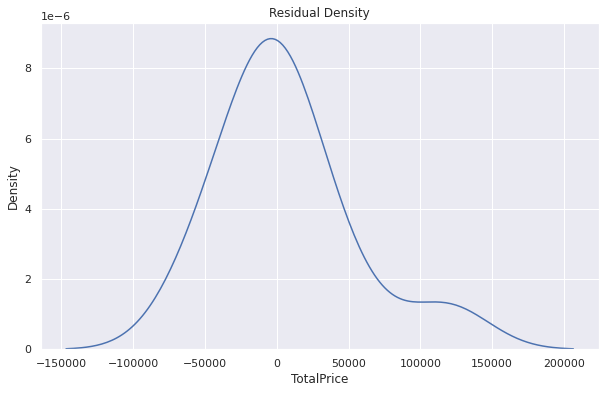

In [71]:
sns.kdeplot(decompose.resid).set_title("Residual Density")
plt.show()

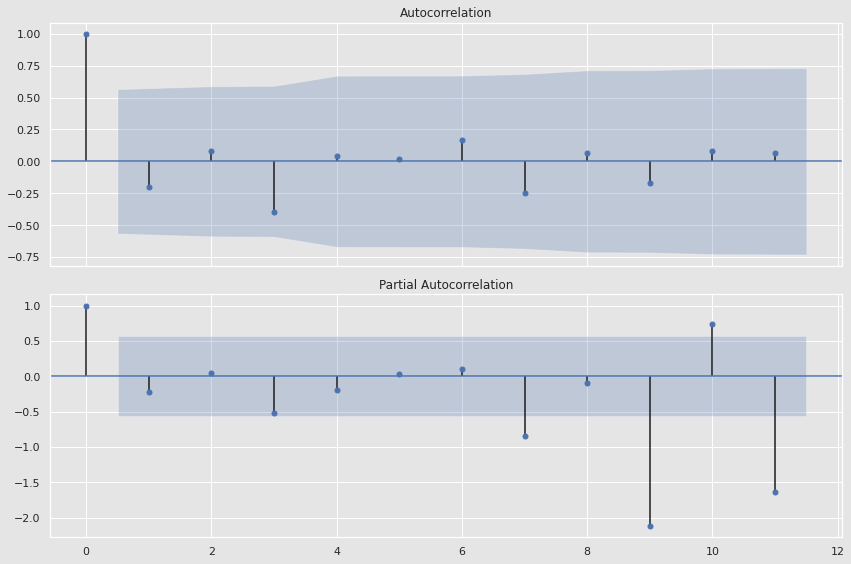

In [72]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (12, 8), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
plot_acf(revenue_monthly["TotalPrice"].diff(1).dropna(), ax = axes[0])
plot_pacf(revenue_monthly["TotalPrice"].diff(1).dropna(), ax = axes[1])

plt.tight_layout()
plt.show()

In [73]:
monthly_data = revenue_monthly[["TotalPrice"]].dropna().reset_index().rename(columns={'InvoiceDate': 'ds', 'TotalPrice': 'y'})
monthly_data


,ds,y
0,2010-12-31,496477.340
1,2011-01-31,440876.330
2,2011-02-28,354618.200
3,2011-03-31,465784.190
4,2011-04-30,408733.111
5,2011-05-31,550359.350
6,2011-06-30,523775.590
7,2011-07-31,484545.591
8,2011-08-31,497194.910
9,2011-09-30,794802.792


In [74]:
model = Prophet(
    daily_seasonality = True, 
    weekly_seasonality = True,
    yearly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
)

model.add_country_holidays(country_name = "UK")

model.fit(monthly_data)

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


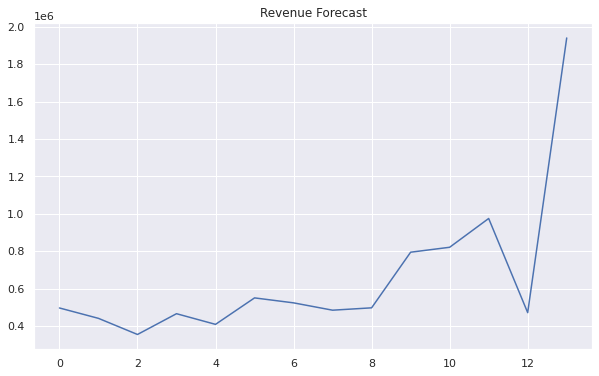

In [76]:
future = model.make_future_dataframe(periods = 1)
forecast = model.predict(future)
plt.title("Revenue Forecast")
plt.plot(forecast["yhat"])

Above graph shows forecast of revenues for next month. Facebook Prophet model predicts steep increase in the revenues for this time period. However, one should note that dataset is not so suitable for forecasting as there is not more observations than 1 year data.